[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrrajeshreddy/TGS-Salt-Identification/blob/master/TGS_salt_identification_Xception.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from sklearn.model_selection import train_test_split, KFold
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import os
import functools
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img


In [2]:
source_dir = './tgs-salt-identification-challenge'
train_images_dir = os.path.join(source_dir,'train','images')
train_masks_dir = os.path.join(source_dir,'train','masks')
print('Training images:', train_images_dir)
print('Training masks:', train_masks_dir)

Training images: ./tgs-salt-identification-challenge/train/images
Training masks: ./tgs-salt-identification-challenge/train/masks


In [0]:
def load_data(target_size=(128,128)):
  train_df = pd.read_csv( os.path.join(source_dir,'train.csv') )
  train_df.count()
  
  def _get_name(idx, path_name):
    file_name = "{}.png".format(idx)
    file_name = os.path.join(path_name, file_name)
    return file_name  

  train_images = []
  train_masks = []
  for idx in train_df.id:
    image_path = _get_name(idx, train_images_dir)
    mask_path = _get_name(idx, train_masks_dir)
    image= img_to_array(load_img(image_path, color_mode = "grayscale", target_size=target_size))
    mask = img_to_array(load_img(mask_path,color_mode = "grayscale", target_size=target_size))
    train_images.append(image)
    train_masks.append(mask)
  train_images = np.array(train_images)
  train_masks = np.array(train_masks)    
  return train_images,train_masks

In [4]:
train_images, train_masks = load_data()
train_images.shape

(4000, 128, 128, 1)

In [0]:
def vis_data(images, masks, num_samples=10):
  grid_count = 0
  choice = np.random.choice(images.shape[0], num_samples)
  plt.figure(figsize=(3*2,num_samples*2))
  grid_spec = gridspec.GridSpec(num_samples, 3, hspace=0.1, wspace=0.01 )
  for indx in choice:
    img = images[indx] / 255
    msk = masks[indx] / 255
    
    plt.subplot(grid_spec[grid_count,0] )
    plt.imshow(img[:,:,0], cmap='gray')
    plt.axis('off')
    
    plt.subplot(grid_spec[grid_count,1])
    plt.imshow(msk[:,:,0], cmap='gray')
    plt.axis('off')
    
    plt.subplot(grid_spec[grid_count,2])
    plt.imshow(img[:,:,0])
    plt.imshow(msk[:,:,0], alpha=0.2, cmap="seismic")
    plt.axis('off')
    
    grid_count += 1
  
  plt.show()
    

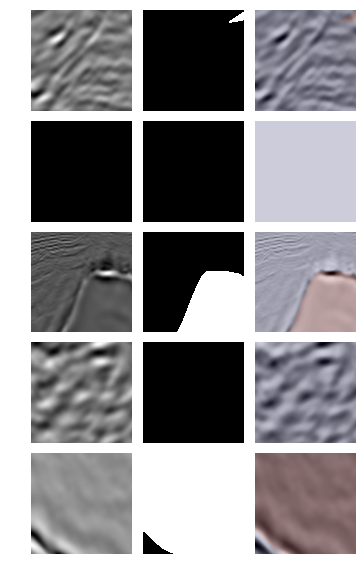

In [6]:
vis_data(train_images, train_masks, 5)

In [0]:
img_shape = (128, 128, 1)
batch_size = 8
epochs = 100

In [0]:
def _scale(image, label, scale=1/255):
  label_img = label * scale
  image = image * scale
  return image, label_img

In [0]:
def _image_flip(image, label, horizontal_flip):
  if horizontal_flip:
      flip_prob = tf.random_uniform([], 0.0, 1.0)
      image, label = tf.cond(tf.less(flip_prob, 0.5),
                              lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                              lambda: (image, label))
  return image, label

In [0]:
def _image_shift(image, label, width_shift_range, height_shift_range):
  if width_shift_range or height_shift_range:
      if width_shift_range:
          width_shift_range = tf.random_uniform([], 
                                            -width_shift_range * img_shape[1],
                                            width_shift_range * img_shape[1])
      if  height_shift_range:
          height_shift_range = tf.random_uniform([],
                                             -height_shift_range * img_shape[0],
                                             height_shift_range * img_shape[0])
      image = tfcontrib.image.translate(image,
                                          [width_shift_range, height_shift_range])
      label = tfcontrib.image.translate(label,
                                          [width_shift_range, height_shift_range])
  return image, label

In [0]:
def _augment(image, 
             label,
             scale=1,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0
            ):
  image, label = _image_flip(image, label, horizontal_flip)
  image, label = _image_shift(image, label, width_shift_range, height_shift_range)
  image, label = _scale(image, label, scale=scale)
  return image, label

In [0]:
def get_dataset(images,
                labels, 
                threads=5, 
                batch_size=10,
                shuffle=True,
                preproc_fn=functools.partial(_augment),
                resize=True,
                scale=1/255,
               ):
    num_x = 20
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    if shuffle:
        dataset = dataset.shuffle(num_x)
    
    dataset = dataset.repeat().batch(batch_size, drop_remainder=True)
    return dataset

In [0]:
tr_cfg = {
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'scale': 1 / 255.,
    'horizontal_flip': False,
    'width_shift_range': None,
    'height_shift_range': None
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)


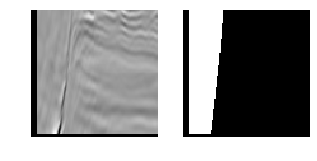

In [15]:
temp_ds = get_dataset(train_images, 
                      train_masks,
                      preproc_fn=tr_preprocessing_fn,
                      batch_size=1,
                      shuffle=True)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    imgs, lbls = sess.run(next_element)
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(lbls[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.show()

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same' )(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def xception_block(input_tensor, num_filters):
  residual = layers.Conv2D(num_filters, (1, 1), padding='same' )(input_tensor)
  residual = layers.BatchNormalization()(residual)
  encoder = layers.Activation('relu')(input_tensor)
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same' )(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same' )(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.add([encoder, residual])
  return encoder
  
def encoder_block(input_tensor, num_filters, use_xception=False):
  if use_xception:
    encoder = xception_block(input_tensor, num_filters)
  else:
    encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  encoder_pool = layers.Dropout(0.5)(encoder_pool)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.Dropout(0.5)(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
def get_model():
  inputs = layers.Input(shape=img_shape )
  encoder0_pool, encoder0 = encoder_block(inputs, 32)
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64,  use_xception=True)
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128, use_xception=True)
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256, use_xception=True)
  center = conv_block(encoder3_pool, 1024)
  decoder3 = decoder_block(center, encoder3, 256)
  decoder2 = decoder_block(decoder3, encoder2, 128)
  decoder1 = decoder_block(decoder2, encoder1, 64)
  decoder0 = decoder_block(decoder1, encoder0, 32)
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
  model = models.Model(inputs=[inputs], outputs=[outputs])
  return model

In [0]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [0]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

In [0]:
def mean_iou(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)) - intersection
  loss = (intersection + smooth) / ( union + smooth)
  return loss

In [0]:
def train_model(epochs, callback):
  x_train, x_val, y_train, y_val = train_test_split( train_images, train_masks )
  train_ds = get_dataset(x_train,
                         y_train,
                         preproc_fn=tr_preprocessing_fn,
                         batch_size=batch_size)
  val_ds = get_dataset(x_val,
                       y_val, 
                       preproc_fn=val_preprocessing_fn,
                       batch_size=batch_size)   
  num_train_examples = x_train.shape[0]
  num_val_examples = x_val.shape[0]

  history = model.fit(train_ds, 
                      steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                      epochs=epochs,
                      validation_data=val_ds,
                      validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                      callbacks=callback)   
  return history

In [0]:
training_history = []

In [0]:
K.clear_session()
model = get_model()

In [0]:
save_weight_path = './gdrive/My Drive/model/TGS_model_bce_dice_loss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_weight_path, save_weights_only=True, monitor='val_dice_loss', save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_loss', mode = 'max',factor=0.5, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer='nadam', loss=bce_dice_loss, metrics=[dice_loss, mean_iou, bce_dice_loss, 'binary_crossentropy'])

In [30]:
callback = [cp, reduce_lr]
epochs=20
history = train_model(epochs, callback)
train_history.append(history)

Epoch 1/20
374/375 [============================>.] - ETA: 0s - loss: 7.0861 - dice_loss: 0.4818 - mean_iou: 0.3701 - bce_dice_loss: 0.8858 - binary_crossentropy: 0.4040
Epoch 00001: val_dice_loss improved from inf to 0.56832, saving model to ./gdrive/My Drive/model/TGS_model_bce_dice_loss.h5
375/375 [==============================] - 124s 330ms/step - loss: 7.0851 - dice_loss: 0.4817 - mean_iou: 0.3701 - bce_dice_loss: 0.8856 - binary_crossentropy: 0.4040 - val_loss: 18.6596 - val_dice_loss: 0.5683 - val_mean_iou: 0.2872 - val_bce_dice_loss: 2.3325 - val_binary_crossentropy: 1.7641
Epoch 2/20
374/375 [============================>.] - ETA: 0s - loss: 5.7346 - dice_loss: 0.3808 - mean_iou: 0.4700 - bce_dice_loss: 0.7168 - binary_crossentropy: 0.3360
Epoch 00002: val_dice_loss improved from 0.56832 to 0.35057, saving model to ./gdrive/My Drive/model/TGS_model_bce_dice_loss.h5
375/375 [==============================] - 110s 293ms/step - loss: 5.7403 - dice_loss: 0.3810 - mean_iou: 0.4698

NameError: ignored

In [0]:
training_history.append(history)

In [0]:
def plot_histor(history):
  dice = history.history['dice_loss']
  val_dice = history.history['val_dice_loss']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  iou = history.history['mean_iou']
  val_iou = history.history['val_mean_iou']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 3, 1)
  plt.plot(epochs_range, dice, label='Training Dice Loss')
  plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Dice Loss')

  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, iou, label='Training IOU')
  plt.plot(epochs_range, val_iou, label='Validation IOU')
  plt.legend(loc='upper right')
  plt.title('Training and Validation loss')  

In [0]:
K.clear_session()
del model
model = get_model()
model.load_weights(save_weight_path)

In [0]:
save_weight_path = './gdrive/My Drive/model/TGS_model_bce_loss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_weight_path, save_weights_only=True, monitor='val_dice_loss', save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_loss', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=[dice_loss, mean_iou, bce_dice_loss, 'binary_crossentropy'])

In [36]:
callback = [cp, reduce_lr]
epochs=20
history = train_model(epochs, callback)

Epoch 1/20
374/375 [============================>.] - ETA: 0s - loss: 1.7246 - dice_loss: 0.3101 - mean_iou: 0.5480 - bce_dice_loss: 0.5257 - binary_crossentropy: 0.2156
Epoch 00001: val_dice_loss improved from inf to 0.37362, saving model to ./gdrive/My Drive/model/TGS_model_bce_loss.h5
375/375 [==============================] - 126s 336ms/step - loss: 1.7234 - dice_loss: 0.3102 - mean_iou: 0.5479 - bce_dice_loss: 0.5256 - binary_crossentropy: 0.2154 - val_loss: 3.0434 - val_dice_loss: 0.3736 - val_mean_iou: 0.4716 - val_bce_dice_loss: 0.7541 - val_binary_crossentropy: 0.3804
Epoch 2/20
374/375 [============================>.] - ETA: 0s - loss: 1.7150 - dice_loss: 0.3134 - mean_iou: 0.5415 - bce_dice_loss: 0.5278 - binary_crossentropy: 0.2144
Epoch 00002: val_dice_loss improved from 0.37362 to 0.24034, saving model to ./gdrive/My Drive/model/TGS_model_bce_loss.h5
375/375 [==============================] - 111s 296ms/step - loss: 1.7180 - dice_loss: 0.3151 - mean_iou: 0.5401 - bce_dice

NameError: ignored

In [0]:
training_history.append(history)

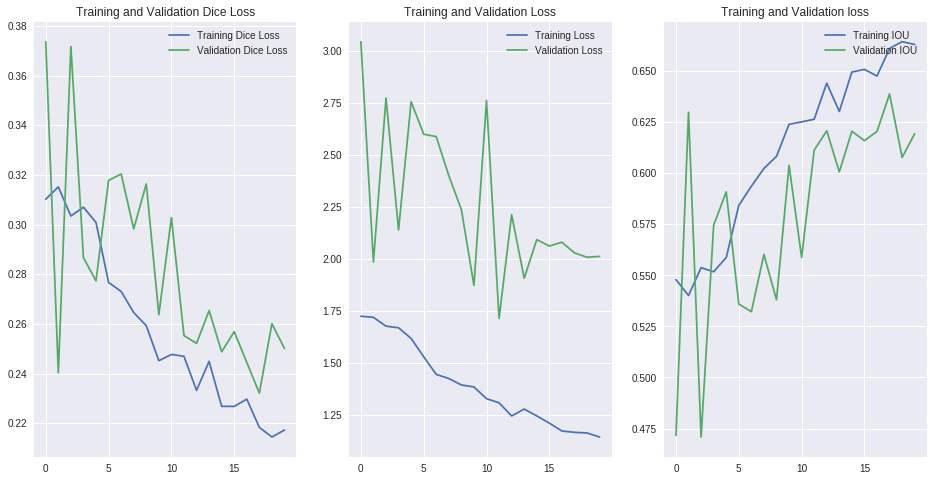

In [39]:
plot_histor(history)

In [0]:
K.clear_session()
del model
model = get_model()
model.load_weights(save_weight_path)

In [0]:
save_weight_path = './gdrive/My Drive/model/TGS_model_bce_dice_loss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_weight_path, save_weights_only=True, monitor='val_dice_loss', save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_loss', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, mean_iou, bce_dice_loss, 'binary_crossentropy'])

Epoch 1/20
374/375 [============================>.] - ETA: 0s - loss: 3.4426 - dice_loss: 0.2257 - mean_iou: 0.6553 - bce_dice_loss: 0.4303 - binary_crossentropy: 0.2046
Epoch 00001: val_dice_loss improved from inf to 0.21964, saving model to ./gdrive/My Drive/model/TGS_model_bce_dice_loss.h5
375/375 [==============================] - 131s 349ms/step - loss: 3.4359 - dice_loss: 0.2253 - mean_iou: 0.6559 - bce_dice_loss: 0.4295 - binary_crossentropy: 0.2042 - val_loss: 3.6918 - val_dice_loss: 0.2196 - val_mean_iou: 0.6576 - val_bce_dice_loss: 0.4615 - val_binary_crossentropy: 0.2418
Epoch 2/20
374/375 [============================>.] - ETA: 0s - loss: 3.3570 - dice_loss: 0.2163 - mean_iou: 0.6657 - bce_dice_loss: 0.4196 - binary_crossentropy: 0.2033
Epoch 00002: val_dice_loss did not improve from 0.21964
375/375 [==============================] - 110s 294ms/step - loss: 3.3560 - dice_loss: 0.2162 - mean_iou: 0.6659 - bce_dice_loss: 0.4195 - binary_crossentropy: 0.2033 - val_loss: 7.3891

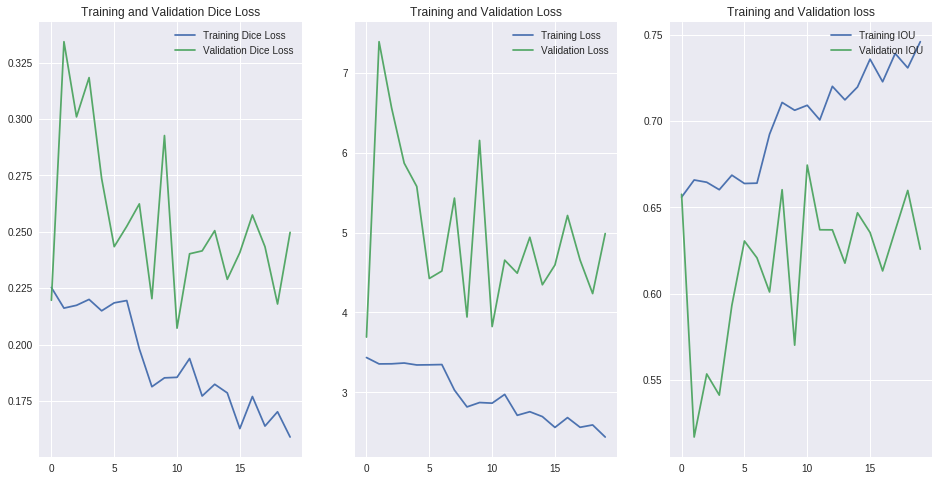

In [42]:
callback = [cp, reduce_lr]
epochs=20
history = train_model(epochs, callback)
training_history.append(history)
plot_histor(history)

In [0]:
model.save_weights('./gdrive/My Drive/model/TGS_model_final.h5')

In [0]:
K.clear_session()
del model
model = get_model()
model.load_weights(save_weight_path)

In [0]:
x_train, x_val, y_train, y_val = train_test_split( train_images, train_masks )
val_ds = get_dataset(x_val,
                     y_val, 
                     preproc_fn=val_preprocessing_fn,
                     batch_size=batch_size)   

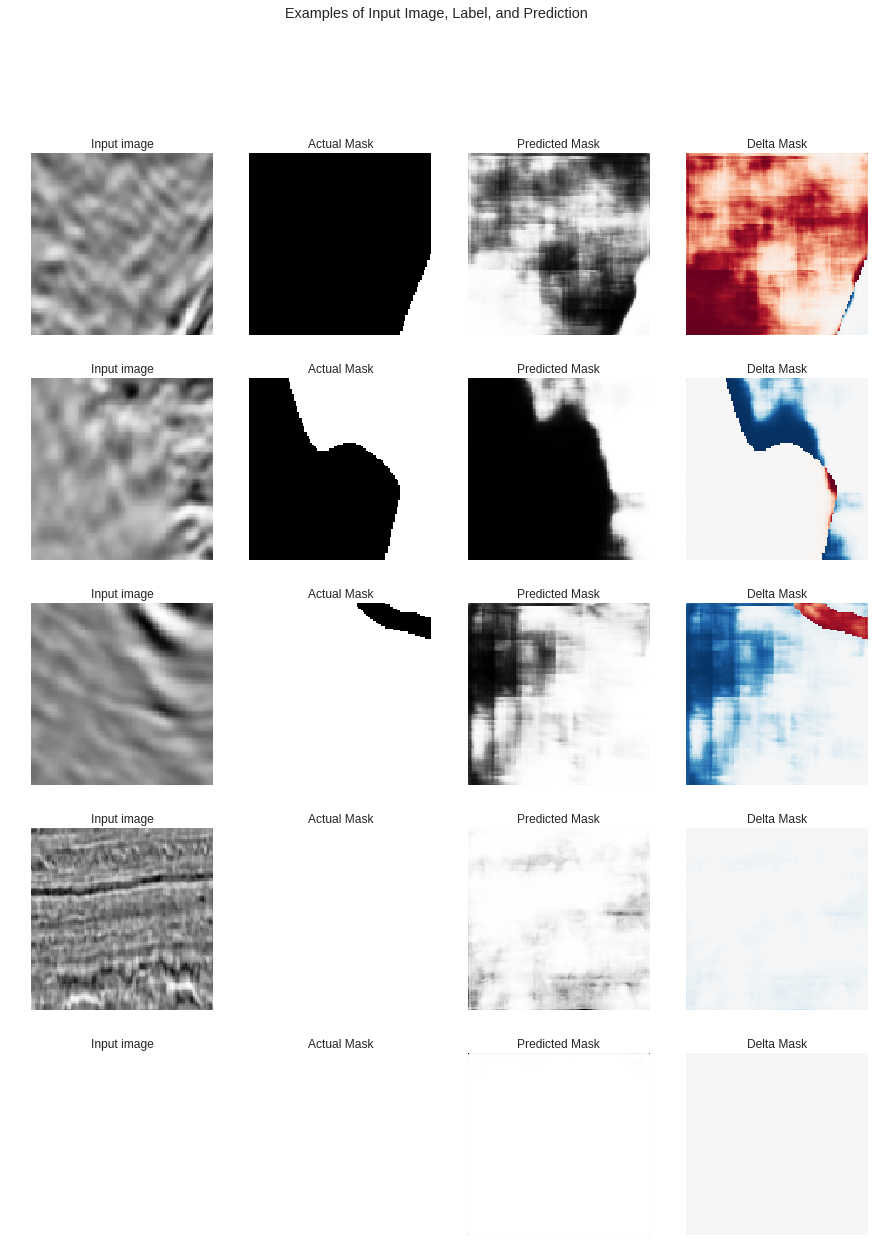

In [59]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(15, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    #next_element = data_aug_iter.get_next() -- use this for eager
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title("Input image")
    
    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label[0, :, :, 0])
    plt.axis('off')
    plt.title("Actual Mask")
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label[:, :, 0])
    plt.axis('off')
    plt.title("Predicted Mask")
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow((predicted_label[:, :, 0]-label[0, :, :, 0]), cmap = 'RdBu', vmin = -1, vmax = 1)
    plt.axis('off')
    plt.title("Delta Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()